In [ ]:
# DeCET application to breast cancer data

In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
plt.rcParams.update({"text.color": 'k'})
rcParams['pdf.fonttype'] = 42

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '5_11_20' # Change this to today's date for output names.

input_dir = '../DeCET_breast_cancer/' # directory where the HOSVD files can be found
file_prefix = 'DeCET_BCCL_final' # prefix used for input files

output_dir = '../' # directory to write output

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1]), int(l[0].split(',')[2])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_gr = 2
n_pt = 13
n_as = 3
n_loc = len(index)
fp.close()

sample_proj = np.zeros((n_gr, n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1], index[k][2]] = projections[k]
assay_name = ['H3K27ac', 'H3K4me3', 'H3K4me1']

78 78


In [3]:
# Read in the HOSVD core tensor and matrices
S = torch.load(input_dir + file_prefix + '_core_tensor.pt')
U0 = torch.load(input_dir + file_prefix + '_factor_matrix_0.pt')
U1 = torch.load(input_dir + file_prefix + '_factor_matrix_1.pt')
U2 = torch.load(input_dir + file_prefix + '_factor_matrix_2.pt')

# The decomposition of the replicate space. The first
# vector captures common features of the replicates
# and the second captures features differing between
# the two replicates.
print(U0)

# Project onto the common features between the two
# replicates. This provides a consensus profile for
# the replicates.
import tensorly
tensorly.set_backend('pytorch')
CL_proj = tensorly.tenalg.mode_dot(S, U1, 1)
CL_proj = tensorly.tenalg.mode_dot(CL_proj, U2, 2)
CL_proj.shape

tensor([[ 0.6611, -0.7503],
        [ 0.7503,  0.6611]], dtype=torch.float64)


Using numpy backend.
Using pytorch backend.


torch.Size([2, 13, 3, 78])

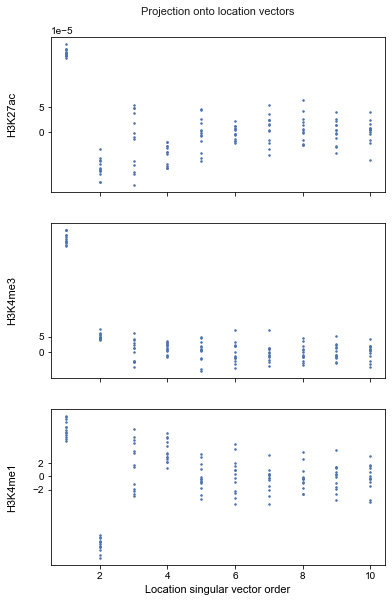

In [4]:
# Stacked projections
fig = plt.figure(figsize=(6,20))

n_proj = 10

ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(611+k))
    for i in range(n_pt):
        ax[k].plot(CL_proj[0, i, k][0:n_proj],'.', markersize=3, c='b')

    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)
        
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    ax[k].get_yaxis().set_label_coords(-0.1,0.5)
    if(k == 0):
        plt.yticks([0,5*10**-5])
    elif(k == 1):
        plt.yticks([0,5*10**-5])
    else:
        plt.yticks([-2*10**-5,0,2*10**-5])
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])
    plt.setp(ax[k].get_xticklabels(), visible=True)
    plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

In [5]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Select the location vectors to use for clustering.
use = []
assay_std = [[np.std(CL_proj[0,:,k,l].numpy()) for l in range(n_loc)] for k in range(n_as)]
for k in range(n_as):
    print(np.argsort(assay_std[k])[-4:])
    for l in range(1, 5):
        if(np.argsort(assay_std[k])[-l] not in use):
            use.append(np.argsort(assay_std[k])[-l])
print(np.sort(use))

tissue_sample = np.copy(CL_proj[0,:,:,use])
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)

D = np.zeros((n_pt, n_pt))
for i in range(n_pt):
    for j in range(n_pt):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

[7 6 4 2]
[6 5 4 2]
[8 4 5 2]
[2 4 5 6 7 8]
(13, 3, 6)


In [6]:
# Cell line labels. This is the order of cell lines
# used in the tensor.
cell_lines = ['76NF2V', 'MCF10A', 'MCF7', 'ZR751', 'MB361',
              'UACC812', 'SKBR3', 'AU565', 'HCC1954', 'MB231',
              'MB436', 'MB468', 'HCC1937']

# Labels for the assay and location indices.
assay_colors = [(51/255,70/255,0,1.0), (204/255,102/255,0,1.0), (162/255,148/255,80/255,1.0)]
index_order = []
col_loc_color = []
single_col_color = []
col_assay = []
for l in range(len(use)):
    if(l % 2 == 0):
        single_col_color.append('k')
    else:
        single_col_color.append((0.5,0.5,0.5,1))
    for k in range(n_as):
        index_order.append(len(use)*k + l)
        col_assay.append(assay_colors[k])
    if(l % 2 == 0):
        for k in range(n_as):
            col_loc_color.append('k')
    else:
        for k in range(n_as):
            col_loc_color.append((0.5,0.5,0.5,1))
            
col_index = []
for i in range(len(use)):
    col_index.append(np.sort(use)[i] + 1)
    col_index.append(np.sort(use)[i] + 1)
    col_index.append(np.sort(use)[i] + 1)

# Colors and labels for the subtypes.
subtype_color = [(0.6,0.6,0.6,1.0), (0.6,0.6,0.6,1.0),
                 (0/255,200/255,0/255,1.0), (0/255,200/255,0/255,1.0),
                 (0/255,0/255,180/255,1.0), (0/255,0/255,180/255,1.0),
                 (128/255,0/255,180/255,1.0), (128/255,0/255,180/255,1.0), (255/255,128/255,0,1.0),
                 (200/255,0/255,0/255,1.0), (200/255,0/255,0/255,1.0),
                 (255/255,128/255,0,1.0), (255/255,128/255,0,1.0)]
subtype_label = ['Normal immortalized', 'Normal immortalized',
                 'Luminal A', 'Luminal A',
                 'Luminal B', 'Luminal B',
                 'Luminal-HER2', 'Luminal-HER2', 'Basal',
                 'Claudin low', 'Claudin low',
                 'Basal', 'Basal']

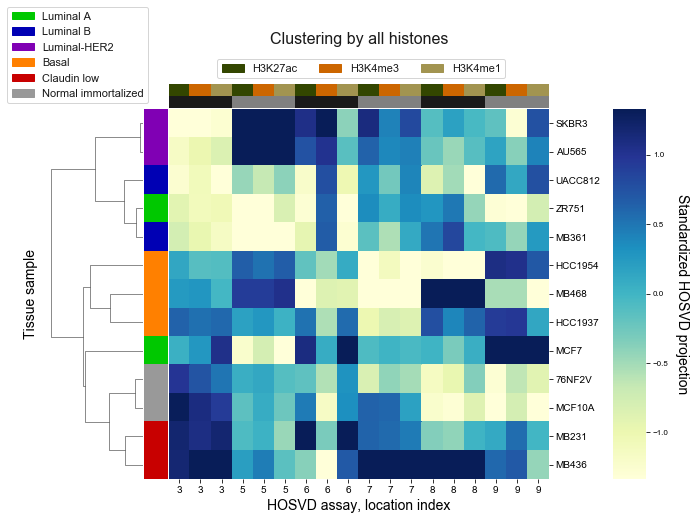

In [7]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.legend import Legend
# Figure 3A (unsupervised hierarchical clustering of tissue samples)

legend_ST = [mpatches.Patch(color=c, label=l) for c,l in zip([subtype_color[2], subtype_color[5],
                                                              subtype_color[7], subtype_color[11],
                                                              subtype_color[9], subtype_color[0]],
                                                             [subtype_label[2], subtype_label[5],
                                                              subtype_label[7], subtype_label[11],
                                                              subtype_label[9], subtype_label[0]])]

legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(assay_colors, assay_name)]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((CL_proj[0,:,0][:,np.sort(use)],
                                   CL_proj[0,:,1][:,np.sort(use)],
                                   CL_proj[0,:,2][:,np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False,
                       col_colors=[col_assay, col_loc_color], row_colors=subtype_color,
                       xticklabels=col_index , yticklabels=cell_lines, figsize=(9,9),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=14, labelpad=20)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.44,1.0), handles=legend_ST,
                       frameon=True, fontsize=11)
g.cax.legend(loc='lower left', bbox_to_anchor=(-12.4,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=3)

g.ax_heatmap.set_title('Clustering by all histones\n', fontsize=16, pad=48)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=14)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=14)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

g.savefig(output_dir + 'figures/figure3_panels/'+ file_prefix + '_panelA_clustering_' +
          date + '.pdf', format='pdf', transparent=True)

In [8]:
# Read in the decomposition of the location space
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_3.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1518186, 78)


In [9]:
# The genomic bins used for the hg19 genome. chrY is 
# removed from the data before the HOSVD. Since chrY is
# at the end of the chromosome list used, this is
# not a problem.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [10]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the mode with greatest between condition separation.
loc_vec = 2

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,loc_vec] > cut):
        significant_pos.append(i)
    elif(U_l[i,loc_vec] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

# Save the regions exhibiting epigenetic alterations 
# between leiomyoma and myometrium. 1-based indexing
# is used for the file names.

output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(loc_vec+1) + '_final.txt','w+')

for l in range(0,len(significant_pos)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0], genomic_bin[significant_pos[l]][1], genomic_bin[significant_pos[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(loc_vec+1) + '_final.txt','w+')

for l in range(0,len(significant_neg)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0], genomic_bin[significant_neg[l]][1], genomic_bin[significant_neg[l]][2]))
output_neg.close()

552 positive
1050 negative


In [11]:
import pandas as pd
df_ex_table = pd.read_excel(input_dir + '12864_2018_4533_MOESM17_ESM.xlsx', header=0,
                            index_col=0, convert_float=False, usecols=list(range(1,28)))
df_ex_table

,76NF2V.REP1,76NF2V.REP2,MCF10A.REP1,MCF10A.REP2,MCF7.REP1,MCF7.REP2,ZR751.REP1,ZR751.REP2,MB361.REP1,MB361.REP2,...,HCC1954.REP1,HCC1954.REP2,MB231.REP1,MB231.REP2,MB436.REP1,MB436.REP2,MB468.REP1,MB468.REP2,HCC1937.REP1,HCC1937.REP2
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,34.35000,32.40000,29.95000,21.75000,11.60000,10.45000,15.40000,17.35000,28.20000,28.05000,...,117.50000,56.90000,29.90000,32.8500,17.95000,25.15000,108.5000,93.95000,83.30000,80.0500
TNMD,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05350,...,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.3155,0.23000,0.00000,0.0000
DPM1,89.30000,84.90000,44.60000,49.05000,128.00000,147.50000,60.90000,50.45000,95.60000,84.55000,...,173.00000,109.00000,35.65000,68.4000,101.00000,128.50000,124.0000,105.50000,145.00000,141.5000
SCYL3,3.30000,3.10500,11.55000,8.17000,4.48000,4.81000,28.35000,25.65000,8.86500,9.45000,...,3.08500,5.56000,8.35000,5.7650,5.84500,6.68000,15.1000,5.88500,8.28000,6.2800
C1orf112,6.07500,6.04500,1.47000,1.97500,2.47500,2.56500,5.62500,3.76500,4.13000,4.10000,...,2.67500,7.17500,2.64000,8.2050,3.86500,4.12500,4.9700,4.48000,5.98500,9.4600
FGR,0.21950,0.09490,2.08500,0.31650,0.00000,0.00000,0.00000,0.02675,0.00000,0.03735,...,0.00000,0.00000,0.30800,0.0000,0.00000,0.86850,0.1095,0.05350,1.48500,0.7835
CFH,6.02000,5.86500,1090.00000,421.00000,0.10250,0.21805,0.03040,0.00000,0.22300,0.09800,...,16.20000,30.10000,19.25000,15.2500,0.00000,0.13750,0.0000,0.00000,0.07700,0.0000
FUCA2,97.65000,107.00000,9.97000,9.63000,155.00000,136.50000,65.40000,65.05000,145.00000,128.00000,...,194.50000,144.50000,130.50000,162.0000,190.00000,255.50000,99.5500,107.50000,126.00000,150.5000
GCLC,217.00000,164.00000,72.60000,67.35000,79.50000,94.00000,53.85000,50.05000,135.50000,118.50000,...,359.50000,173.00000,188.00000,98.2500,52.05000,91.00000,134.0000,163.00000,173.00000,69.2000


In [12]:
df_ex_table.loc['PGR']

76NF2V.REP1        0.74600
76NF2V.REP2        0.55500
MCF10A.REP1        0.13250
MCF10A.REP2        0.04710
MCF7.REP1          0.12400
MCF7.REP2          0.06800
ZR751.REP1         5.04500
ZR751.REP2         3.58000
MB361.REP1       166.50000
MB361.REP2       462.50000
UACC812.REP1    1110.00000
UACC812.REP2     839.00000
SKBR3.REP1         0.03960
SKBR3.REP2         0.04920
AU565.REP1         1.20000
AU565.REP2         0.37450
HCC1954.REP1       0.60500
HCC1954.REP2       0.60000
MB231.REP1         0.00000
MB231.REP2         0.11275
MB436.REP1         0.24200
MB436.REP2         0.41700
MB468.REP1         0.00000
MB468.REP2         0.00000
HCC1937.REP1       0.46550
HCC1937.REP2       0.30500
Name: PGR, dtype: float64

In [13]:
df_ex_table.loc['ESR1']

76NF2V.REP1       2.46500
76NF2V.REP2       1.94000
MCF10A.REP1       0.43050
MCF10A.REP2       0.24810
MCF7.REP1        12.80000
MCF7.REP2        10.54000
ZR751.REP1       11.35000
ZR751.REP2       12.35000
MB361.REP1      208.00000
MB361.REP2      253.00000
UACC812.REP1    124.00000
UACC812.REP2    153.00000
SKBR3.REP1        0.62850
SKBR3.REP2        0.40600
AU565.REP1        5.45000
AU565.REP2        5.71000
HCC1954.REP1      2.57500
HCC1954.REP2      2.06000
MB231.REP1        0.11020
MB231.REP2        0.14100
MB436.REP1        0.00000
MB436.REP2        0.03025
MB468.REP1       10.84000
MB468.REP2        5.56500
HCC1937.REP1     14.55000
HCC1937.REP2     14.05000
Name: ESR1, dtype: float64

In [14]:
df_ex_table.loc['ERBB2']

76NF2V.REP1       163.50
76NF2V.REP2       162.00
MCF10A.REP1       256.00
MCF10A.REP2       187.00
MCF7.REP1          47.40
MCF7.REP2          36.10
ZR751.REP1        828.00
ZR751.REP2        953.00
MB361.REP1       1120.00
MB361.REP2       1215.00
UACC812.REP1    10650.00
UACC812.REP2     8305.00
SKBR3.REP1      10600.00
SKBR3.REP2      10400.00
AU565.REP1      10900.00
AU565.REP2       9615.00
HCC1954.REP1     7855.00
HCC1954.REP2    11250.00
MB231.REP1        114.50
MB231.REP2        107.50
MB436.REP1         59.70
MB436.REP2         56.45
MB468.REP1        112.25
MB468.REP2         71.85
HCC1937.REP1       97.00
HCC1937.REP2       87.05
Name: ERBB2, dtype: float64

In [15]:
# List of marker genes.
basal_luminal_genes = ['ESR1', 'GATA3', 'KRT19', 'KRT8', 'KRT18', 'XBP1',
                       'PBX1', 'PATZ1', 'SPDEF', 'CRABP2', 'MUC1', 'FOXA1',
                       'MYB', 'RET', 'EGR3', 'TFF1', 'ERBB3', 'TOB1', 'TFF3', # luminal
                       'ERBB2', 'GRB7' ,'PGAP3', 'STARD3', 'MIEN1', # HER2+
                       'EGFR', 'CAV1', 'CAV2', 'MSN', 'ETS1',
                       'KRT4', 'KRT5', 'KRT6A', 'KRT6B', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17',
                       'ITGA6', 'ITGB4', 'ITGB6',
                       'LAMB3', 'LAMC2', 'TRIM29', 'S100A2', 'SLPI', 'LYN',
                       'ANXA8', 'COL17A1', 'BNC1', 'MET', 'PROM1', 
                       'VTCN1', 'BST2', 'FABP7', 'MME', 'CD14', 'CD58', 'CD59', # basal
                       'VIM', 'SPARC', 'FN1', 'FBN1', 'HAS2', 'COL3A1',
                       'COL6A1', 'COL6A2', 'COL6A3', 'COL8A1', 'MMP2', 'MMP14',
                       'TIMP1', 'CTSC', 'PLAU', 'PLAUR', 'AXL', 'PLAT',
                       'CD44', 'TGFBR2', 'SERPINE1', 'SERPINE2', 'TGFB1' # claudin low
                      ]
# CD24 and GABRK were not found in the expression table.

# Subtype color for the marker genes.
subtype_gene_colors = [(0/255,90/255,120/255,1.0),
                       (90/255,0/255,90/255,1.0),
                       (205/255, 80/255, 0/255,1.0),
                       (163/255, 0/255, 32/255,1.0)]
basal_luminal_gene_colors = [subtype_gene_colors[0] for i in range(19)]
basal_luminal_gene_colors += [subtype_gene_colors[1] for i in range(5)]
basal_luminal_gene_colors += [subtype_gene_colors[2] for i in range(35)]
basal_luminal_gene_colors += [subtype_gene_colors[3] for i in range(23)]

reorder_CLs = [2*i for i in range(n_pt)]
reorder_CLs += [2*i + 1 for i in range(n_pt)]

# Order the cell lines according to the clustering 
# shown in 3A. Replicates for each cell line are
# placed side by side.
cluster_order = [3, 3+n_pt, 4, 4+n_pt, 5, 5+n_pt, 7, 7+n_pt,
                 6, 6+n_pt, 12, 12+n_pt, 11, 11+n_pt, 8, 8+n_pt,
                 2, 2+n_pt, 10, 10+n_pt, 9, 9+n_pt, 1, 1+n_pt, 
                 0, 0+n_pt]

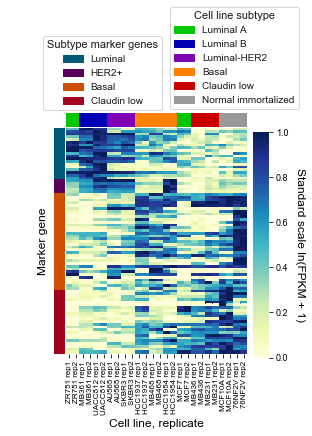

In [16]:
# Figure 3B (expression of marker genes)
cell_lines_replicate = ['76NF2V rep1', 'MCF10A rep1', 'MCF7 rep1', 'ZR751 rep1', 'MB361 rep1',
                        'UACC812 rep1', 'SKBR3 rep1', 'AU565 rep1', 'HCC1954 rep1', 'MB231 rep1',
                        'MB436 rep1', 'MB468 rep1', 'HCC1937 rep1',
                        '76NF2V rep2', 'MCF10A rep2', 'MCF7 rep2', 'ZR751 rep2', 'MB361 rep2',
                        'UACC812 rep2', 'SKBR3 rep2', 'AU565 rep2', 'HCC1954 rep2', 'MB231 rep2',
                        'MB436 rep2', 'MB468 rep2', 'HCC1937 rep2']

legend_ST = [mpatches.Patch(color=c, label=l) for c,l in zip([subtype_color[2], subtype_color[5],
                                                              subtype_color[7], subtype_color[11],
                                                              subtype_color[9], subtype_color[0]],
                                                             [subtype_label[2], subtype_label[5],
                                                              subtype_label[7], subtype_label[11],
                                                              subtype_label[9], subtype_label[0]])]

legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(subtype_gene_colors, ['Luminal',
                                                                                      'HER2+',
                                                                                      'Basal',
                                                                                      'Claudin low'])]

# Make the cluster map. 
g = seaborn.clustermap(np.log(df_ex_table.loc[basal_luminal_genes].values[:,reorder_CLs][:,cluster_order] + 1), cmap="YlGnBu",
                       row_cluster=False, col_cluster=False, robust=False,
                       col_colors=[(subtype_color + subtype_color)[cluster_order[i]] for i in range(2*n_pt)],
                       row_colors=basal_luminal_gene_colors,
                       xticklabels=[cell_lines_replicate[cluster_order[i]] for i in range(2*n_pt)],
                       yticklabels=[],figsize=(4.3,5.5),
                       standard_scale=0)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=8)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([0.92,0.115,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=9)
g.cax.set_ylabel('Standard scale ln(FPKM + 1)', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(0.55,1.06), handles=legend_ST,
                       frameon=True, fontsize=10,
                       title='Cell line subtype', title_fontsize=11)
g.cax.legend(loc='lower left', bbox_to_anchor=(-13.9, 1.075), handles=legend_assay,
                       frameon=True, fontsize=10, ncol=1,
             title='Subtype marker genes', title_fontsize=11)

g.ax_heatmap.set_xlabel('Cell line, replicate', fontsize=12)
g.ax_heatmap.set_ylabel('Marker gene', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.15,0.5)
g.savefig(output_dir + 'figures/figure3_panels/'+ file_prefix + '_panelB_marker_gene_expression_figure_' +
          date + '.pdf', format='pdf', transparent=True)